<a href="https://colab.research.google.com/github/JoeOlang/NLP/blob/main/Swahili/Swahili%20Word%20Embedding%20Word2Vec%20-%20Model/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [64]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [93]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [66]:
train_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/Train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/Test.csv'

In [73]:
df = pd.read_csv(train_path)
df.head(10)

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa
5,SW1002,"Malkia wa Mipasho Afrika Mashariki, Khadija O...",michezo
6,SW1003,"Meneja Masoko na Mawasiliano wa taasisi hiyo,...",Biashara
7,SW1004,IDADI ya vifo vya waendesha bodaboda nchini v...,Kitaifa
8,SW1006,"Katika uzinduzi huo, rais amesema kuna haja y...",Biashara
9,SW1007,Mshindi wa mchezo utakaozikutanisha Tottenham...,michezo


In [74]:
df['len'] = df['content'].apply(lambda s : len(s))

In [79]:
df

,id,content,category,len
0,SW0,serikali imesema haitakuwa tayari kuona amani...,Kitaifa,1584
1,SW1,"mkuu wa mkoa wa tabora, aggrey mwanri amesiti...",Biashara,1317
2,SW10,serikali imetoa miezi sita kwa taasisi zote z...,Kitaifa,2610
3,SW100,kampuni ya mchezo wa kubahatisha ya m-bet ime...,michezo,1404
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu...,Kitaifa,2247
...,...,...,...,...
5146,SW993,rais john magufuli ameendelea kung’ara katika...,Kitaifa,6742
5147,SW994,kampeni inayohimiza watafi ti kuandika upya h...,Kitaifa,2348
5148,SW996,"matukio mapya ya malaria kwa kila watu 1,### ...",Kitaifa,3014
5149,SW997,imeelezwa kuwa hakuna sheria yoyote inayokata...,Kitaifa,1216


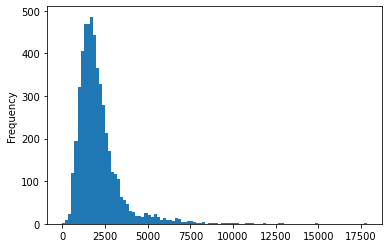

In [76]:
df['len'].plot.hist(bins=100)

In [77]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [78]:
# lower the text
df["content"] = df["content"].apply(lambda x: x.lower())

# Clean the text
df["content"] = df["content"].apply(lambda x: clean_text(x))

# Clean numbers
df["content"] = df["content"].apply(lambda x: clean_numbers(x))

In [81]:
df['category'].unique()

array(['Kitaifa', 'Biashara', 'michezo', 'Kimataifa', 'Burudani'],
      dtype=object)

In [82]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(df['content'], df['category'],
                                                    stratify=df['category'], 
                                                    test_size=0.25)

In [83]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3863,)
Test shape :  (1288,)


In [86]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [87]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [88]:
le.classes_

array(['Biashara', 'Burudani', 'Kimataifa', 'Kitaifa', 'michezo'],
      dtype=object)

In [94]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/embeddings300.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [98]:
import os
word_index = tokenizer.word_index
embedings_index = {}
f = open(os.path.join('', '/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/embeddings300.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedings_index[word] = coefs
f.close()

embedding_dimension = 300
num_words = len(word_index) + 1
embedings_matrix = np.zeros((num_words, embedding_dimension))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedings_vector = embedings_index.get(word)
    if embedings_vector is not None:
        embedings_matrix[i] = embedings_vector

In [100]:
np.shape(embedings_matrix)

(66155, 300)

In [101]:
embedding_matrix = embedings_matrix

In [102]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit


In [103]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

RuntimeError: ignored